In [1]:
import sklearn
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from joblib import dump

In [17]:
data = pd.read_csv('stats_dataset.csv')
data_copy = data.copy()
data.pop('home_name')
data.pop('away_name')

0         Piast Gliwice
1          GKS Katowice
2        Pogoń Szczecin
3         Korona Kielce
4           Stal Mielec
              ...      
18555         Cukaricki
18556           Alkmaar
18557               HJK
18558     Nordsjaelland
18559       Aston Villa
Name: away_name, Length: 18560, dtype: object

In [18]:
data = data[data['result'].notna()]

In [19]:
target = data.pop('result').astype('int8')
target.info()

<class 'pandas.core.series.Series'>
RangeIndex: 18560 entries, 0 to 18559
Series name: result
Non-Null Count  Dtype
--------------  -----
18560 non-null  int8 
dtypes: int8(1)
memory usage: 18.3 KB


In [38]:
def draw_confussion_matrix(y_test, y_pred, model_classes):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_classes)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

def use_cross_validation(model, x, y, n_splits, n_jobs=5):
    scores = cross_val_score(estimator=model, X=x, y=y, cv=n_splits, n_jobs=n_splits)
    print('Mean score CV:', scores.mean())
    print('All scores CV:', scores)
    return scores

In [21]:
cols = data.select_dtypes(include='number').columns
pd.set_option('display.max_rows', None)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, stratify=target)

In [23]:
x_train = x_train.drop(['fortuna_home', 'fortuna_draw', 'fortuna_away', 'superbet_home', 'superbet_draw', 'superbet_away'], axis=1)
x_test = x_test.drop(['fortuna_home', 'fortuna_draw', 'fortuna_away', 'superbet_home', 'superbet_draw', 'superbet_away'], axis=1)

In [24]:
print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)

print('train values:\n', y_train.value_counts(dropna=False))
print('test values:\n', y_test.value_counts(dropna=False))

x_test.pop('match_date')
x_train.pop('match_date')
print(x_train.select_dtypes(include=['object', 'category']).columns.tolist())

x_train shape:  (14848, 290)
y_train shape:  (14848,)
x_test shape:  (3712, 290)
y_test shape:  (3712,)
train values:
 result
1    6508
2    4526
0    3814
Name: count, dtype: int64
test values:
 result
1    1627
2    1132
0     953
Name: count, dtype: int64
[]


In [25]:
from  sklearn.preprocessing import StandardScaler, MinMaxScaler


scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train.values), index=x_train.index, columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test.values), index=x_test.index, columns=x_test.columns)

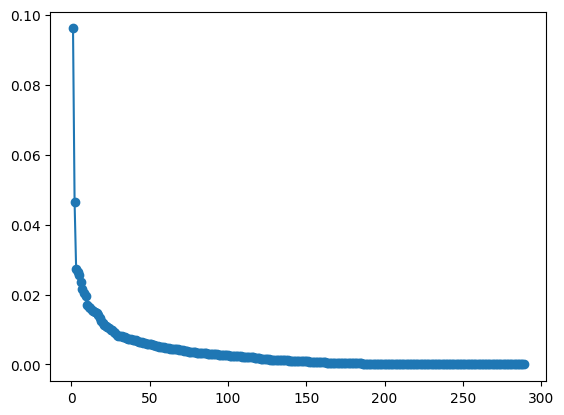

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA()
pca.fit(x_train)
variances = pca.explained_variance_ratio_
plt.plot(np.arange(1, len(variances)+1), variances, marker='o')

In [27]:
pca = PCA(n_components=25)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

In [143]:
model = RandomForestClassifier(n_estimators=300, criterion='entropy',
        max_depth=5, min_samples_split=20, min_samples_leaf=10, max_features='sqrt',)

scores = use_cross_validation(model, x_train, y_train, 5, n_jobs=6)

model.fit(x_train, y_train)

train_score = model.score(x_train, y_train)
test_score = model.score(x_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

y_pred = model.predict(x_test)

print(np.bincount(y_pred))
print('classification report:\n', classification_report(y_test, y_pred))

Mean score CV: 0.49050334942554547
All scores CV: [0.49494949 0.4969697  0.48585859 0.48669586 0.48804311]
Score on training data:  0.5187230603448276
Score on test data:  0.49084051724137934
[   0 2787  925]
classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       953
           1       0.49      0.85      0.62      1627
           2       0.48      0.39      0.43      1132

    accuracy                           0.49      3712
   macro avg       0.33      0.41      0.35      3712
weighted avg       0.36      0.49      0.41      3712



c:\Users\dawid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dawid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dawid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

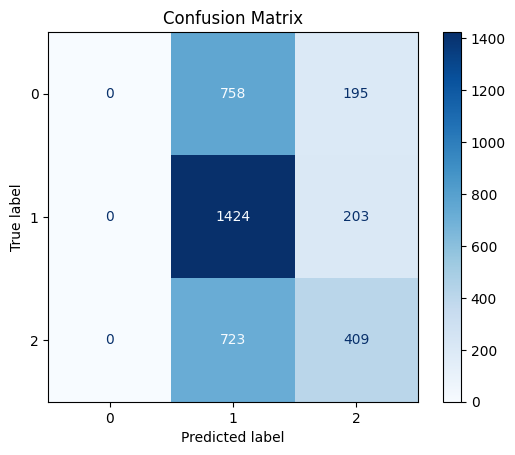

['rfc_0.4938038793103448_acc.joblib']

In [ ]:
draw_confussion_matrix(y_test, y_pred, model.classes_)
# dump(model, f'rfc_{test_score}_acc.joblib')

In [115]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression(class_weight={1 : 1.2, 0 : 1.2, 2 : 1.4})

scores = use_cross_validation(lr, x_train, y_train, n_splits=5)

lr.fit(x_train, y_train)

train_score = lr.score(x_train, y_train)
test_score = lr.score(x_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

y_pred = lr.predict(x_test)

print(np.bincount(y_pred))
print('classification report:\n', classification_report(y_test, y_pred))

Mean score CV: 0.49259118636686844
All scores CV: [0.496633   0.4979798  0.48922559 0.48433816 0.49477939]
Score on training data:  0.4943426724137931
Score on test data:  0.4978448275862069
[   2 2281 1429]
classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       953
           1       0.53      0.75      0.62      1627
           2       0.44      0.56      0.50      1132

    accuracy                           0.50      3712
   macro avg       0.33      0.44      0.37      3712
weighted avg       0.37      0.50      0.42      3712



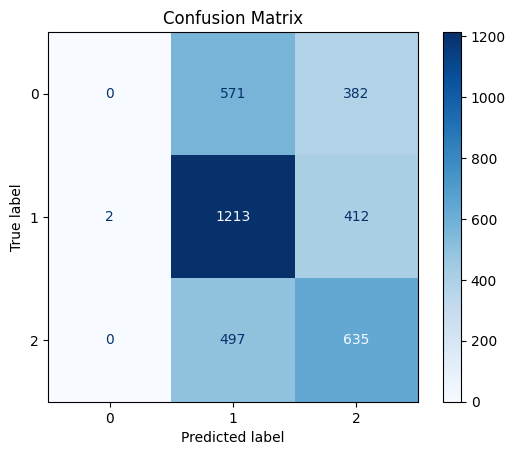

In [116]:
draw_confussion_matrix(y_test, y_pred, lr.classes_)
# dump(model, f'lr_{test_score}_acc.joblib')

In [153]:
from xgboost import XGBClassifier

xgb = XGBClassifier(eval_metric='auc', n_estimators=100, learning_rate=0.15, max_depth=1, alpha=0.6, gamma=0.7)

scores = use_cross_validation(xgb, x_train, y_train, 5, 6)

xgb.fit(x_train, y_train)

train_score = xgb.score(x_train, y_train)
test_score = xgb.score(x_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

y_pred = xgb.predict(x_test)

print(np.bincount(y_pred))
print('classification report:\n', classification_report(y_test, y_pred))

Mean score CV: 0.4930625895193089
All scores CV: [0.4952862  0.5003367  0.49023569 0.48871674 0.49073762]
Score on training data:  0.49986530172413796
Score on test data:  0.4964978448275862
[   4 2638 1070]
classification report:
               precision    recall  f1-score   support

           0       0.50      0.00      0.00       953
           1       0.50      0.82      0.62      1627
           2       0.48      0.45      0.46      1132

    accuracy                           0.50      3712
   macro avg       0.49      0.42      0.36      3712
weighted avg       0.49      0.50      0.42      3712



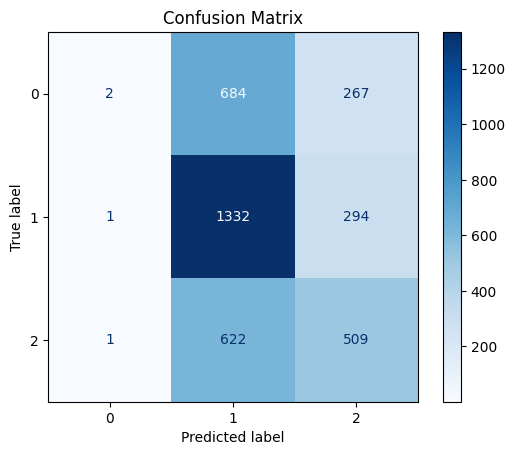

['xgb_0.4964978448275862_acc.joblib']

In [154]:
draw_confussion_matrix(y_test, y_pred, xgb.classes_)
dump(xgb, f'xgb_{test_score}_acc.joblib')

In [170]:
from sklearn.neighbors  import KNeighborsClassifier

kn = KNeighborsClassifier(n_neighbors=25, weights='distance')

scores = use_cross_validation(kn, x_train, y_train, n_splits=5)

kn.fit(x_train, y_train)

train_score = kn.score(x_train, y_train)
test_score = kn.score(x_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

y_pred = kn.predict(x_test)

print('classification report:\n', classification_report(y_test, y_pred))

Mean score CV: 0.47144375153805934
All scores CV: [0.47609428 0.46734007 0.47407407 0.4802964  0.45941394]
Score on training data:  1.0
Score on test data:  0.47009698275862066
classification report:
               precision    recall  f1-score   support

           0       0.29      0.12      0.17       953
           1       0.51      0.71      0.60      1627
           2       0.45      0.42      0.43      1132

    accuracy                           0.47      3712
   macro avg       0.42      0.42      0.40      3712
weighted avg       0.44      0.47      0.44      3712



In [178]:
from sklearn.svm import SVC


svc = SVC(kernel='rbf')

scores = use_cross_validation(svc, x_train, y_train, 5, -1)

svc.fit(x_train, y_train)

train_score = svc.score(x_train, y_train)
test_score = svc.score(x_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

y_pred = svc.predict(x_test)

print(np.bincount(y_pred))
print('classification report:\n', classification_report(y_test, y_pred))

Mean score CV: 0.49279363750902994
All scores CV: [0.49090909 0.5026936  0.48484848 0.49141125 0.49410576]
Score on training data:  0.556573275862069
Score on test data:  0.49084051724137934
[  60 2667  985]
classification report:
               precision    recall  f1-score   support

           0       0.27      0.02      0.03       953
           1       0.50      0.82      0.62      1627
           2       0.48      0.41      0.44      1132

    accuracy                           0.49      3712
   macro avg       0.41      0.42      0.37      3712
weighted avg       0.43      0.49      0.42      3712



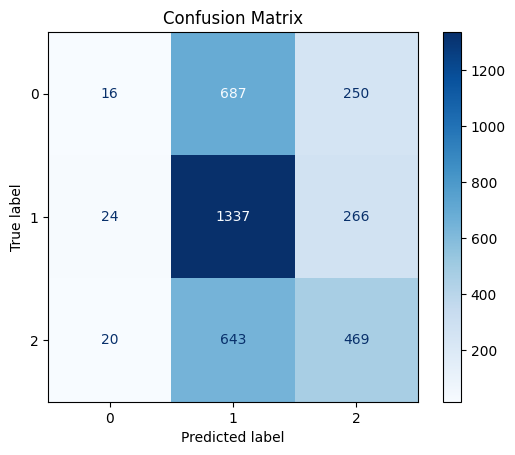

['svc_0.49084051724137934_acc.joblib']

In [180]:
draw_confussion_matrix(y_test, y_pred, svc.classes_)
dump(svc, f'svc_{test_score}_acc.joblib')

In [ ]:
from catboost import CatBoostClassifier


cbc = CatBoostClassifier(iterations=1000, verbose=1, learning_rate=0.001, depth=5, auto_class_weights='Balanced', min_data_in_leaf=15)

scores = use_cross_validation(cbc, x_train, y_train, 5, n_jobs=-1)

cbc.fit(x_train, y_train)

train_score = cbc.score(x_train, y_train)
test_score = cbc.score(x_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

y_pred = cbc.predict(x_test)

print('classification report:\n', classification_report(y_test, y_pred))


In [ ]:
draw_confussion_matrix(y_test, y_pred, cbc.classes_)
dump(cbc, f'svc_{test_score}_acc.joblib')